# Bagnet

### AKA Approximating CNNs with Bag-of-local-Features models works surprisingly well on ImageNet

Wieland Brendel, Matthias Bethge

Waaay back in [2011](https://arxiv.org/abs/1101.3354)

> BoF-based systems have set new performance standards on popular image classification benchmarks and have achieved scalability breakthroughs in image retrieval

# TL;DR

Most modern CNN-based approaches may learn

something similar to a "bag of features",

but definitely are less interpretable.

# Architecture - ResNet*

![residual](./images/residual.PNG)

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
one_by_one_conv = nn.Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))

In [3]:
image = torch.zeros((1, 3, 28, 28))
one_by_one_conv(image).shape

torch.Size([1, 64, 28, 28])

In [4]:
# Each "pixel" in the output is a linear combination of the channels of the input,
# and the weights are the same for all "pixels".

# For the first layer, there's just 64 different combinations of weights for the 3 channels of a pixel

In [5]:
one_by_one_conv.weight.shape

torch.Size([64, 3, 1, 1])

In [6]:
%%html
<img src="images/patch9.jpg" width="600px">

In [7]:
from bagnet_arch import create_bagnet9

bagnet = create_bagnet9()

In [8]:
bagnet

BagNet(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05

In [9]:
bagnet(torch.zeros((1, 3, 64, 64))).shape

pre pool torch.Size([1, 2048, 7, 7])
post pool torch.Size([1, 2048, 1, 1])


torch.Size([1, 1000])


![](./images/MagrittePipe.jpg)

- Speed: 1/3 the FPS of normal ResNet

- Version with 17x17 patches gets ~AlexNet accuracy on ImageNet

- It's about _interpretability_

# Aside - fast.ai hype

- Even higher level on top of PyTorch 1.0
- Deep learning best practices/state of the art baked in
- Jeremy Howard seems to have good opinions [on](https://twimlai.com/twiml-talk-186-the-fastai-v1-deep-learning-framework-with-jeremy-howard/) [podcasts](https://twimlai.com/twiml-talk-214-trends-in-deep-learning-with-jeremy-howard/) on what makes a good API for ML practitioners (as opposed to researchers)
- I type FrostAI every time I try to `import fastai`

## and on Twitter

In [10]:
%%html
<img src="./images/whyFastai.PNG" width="400px">

In [11]:
from fastai.datasets import URLs, untar_data
from fastai.vision import ImageDataBunch, create_cnn

In [12]:
path = untar_data(URLs.MNIST_SAMPLE)
mnist = ImageDataBunch.from_folder(path)

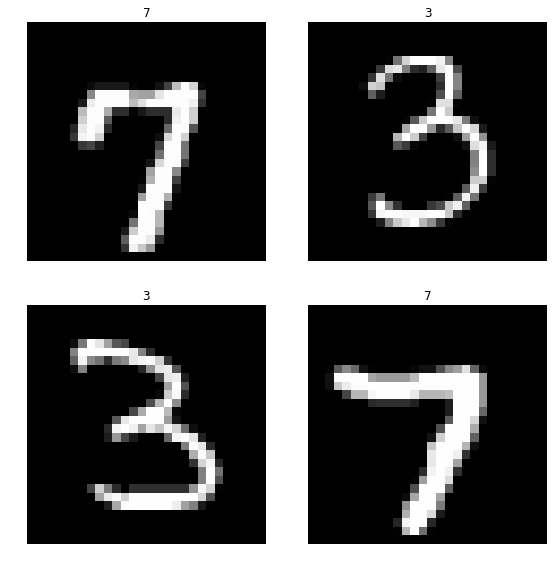

In [13]:
mnist.show_batch(rows=2)

In [14]:
from fastai.vision import create_cnn
from fastai.metrics import accuracy

In [15]:
bagnet = create_bagnet9(num_classes=len(mnist.classes))
bagnet = bagnet.cuda()
learner = create_cnn(
    data=mnist,
    # mmkay I definitely wouldn't've guessed this
    arch=lambda _: bagnet,
    metrics=accuracy,
    pretrained=False
)

In [16]:
learner.fit_one_cycle(cyc_len=10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.153720,2.465011,0.495584
2,0.114076,2.125098,0.511286
3,0.101681,0.579409,0.745829
4,0.109450,4.462045,0.495584
5,0.094012,0.072680,0.973013
6,0.133128,7.017047,0.517664
7,0.062695,0.087459,0.971050
8,0.053171,0.083091,0.974975
9,0.037584,0.066851,0.978901
10,0.033057,0.035648,0.988224


![](./images/wizard.gif)

In [17]:
# learner.save('just_in_case')
# learner.load('just_in_case')

In [18]:
images, labels = mnist.one_batch()

In [19]:
logits = bagnet(images.cuda())
probs = nn.Softmax(dim=-1)(logits)

pre pool torch.Size([64, 2048, 3, 3])
post pool torch.Size([64, 2048, 1, 1])


tensor([0.4169, 0.5831], device='cuda:0', grad_fn=<SelectBackward>)

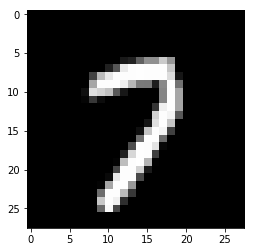

In [20]:
i = 1
img = images[i].cpu().numpy()
plt.imshow(np.rollaxis(img, 0, 3));
probs[i]

In [21]:
def generate_heatmap_pytorch(model, image, target, patchsize):
    with torch.no_grad():
        # pad with zeros
        _, c, x, y = image.shape
        padded_image = np.zeros((c, x + patchsize - 1, y + patchsize - 1))
        padded_image[:, (patchsize-1)//2:(patchsize-1)//2 + x, (patchsize-1)//2:(patchsize-1)//2 + y] = image[0]
        image = padded_image[None].astype(np.float32)
                
        # extract patches
        input = torch.from_numpy(image).cuda()
        patches = input.permute(0, 2, 3, 1)
        patches = patches.unfold(1, patchsize, 1).unfold(2, patchsize, 1)
        num_rows = patches.shape[1]
        num_cols = patches.shape[2]
        patches = patches.contiguous().view((-1, 3, patchsize, patchsize))

        # compute logits for each patch
        logits_list = []
        for batch_patches in torch.split(patches, 1000):
            logits = model(batch_patches)
            logits = logits[:, target]
            logits_list.append(logits.data.cpu().numpy().copy())

        logits = np.hstack(logits_list)
        return logits.reshape((28, 28))

In [22]:
heatmap = generate_heatmap_pytorch(bagnet, img[None], labels[i].cpu().numpy().item(), 9)

pre pool torch.Size([784, 2048, 1, 1])
post pool torch.Size([784, 2048, 1, 1])


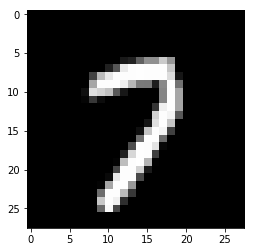

In [23]:
plt.imshow(np.rollaxis(img, 0, 3));

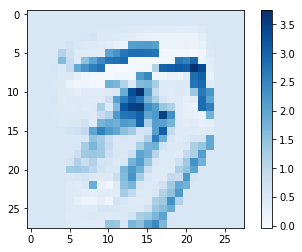

In [24]:
plt.imshow(heatmap, cmap=plt.cm.Blues)
plt.colorbar();

10 14


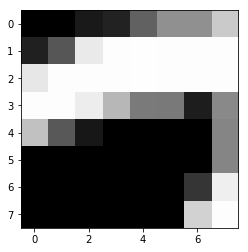

In [25]:
i, j = np.where(heatmap == heatmap.max())
i, j = i[0], j[0]
patch_size = 9
patch = np.rollaxis(img, 0, 3)[
    (i - patch_size // 2):(i + patch_size // 2),
    (j - patch_size // 2):(j + patch_size // 2),
]
print(i, j)
plt.imshow(patch);

# Guilty By Association

- Scrambling only brings down VGG-16 from 90.1% to 79.4% 
![](./images/sadpuppy.PNG)

# Guilty By Association

- The same classes are hard for all networks

![](./images/hardishard.PNG)

# Guilty By Association

- For each image `x`, the difference between evidence for a class with/without a bunch of noise patches is `~=` to the sum of the individual "impacts" of the noise.

![](./images/mathy.PNG)

- Bagnets have this bad, but other networks show it, too (correlation between LHS/RHS)

![](./images/howhigh.PNG)

## Spatially distinct image manipulations do not interact

- Copy the "interesting patch" for a class to multiple places on the image
- BagNet simply averages the likelihood of an "interesting patch" over all patches, so copying a patch will just add to the probaility for the class
- _But_ BagNet isn't alone here, either

In [26]:
import torchvision.models
import torchvision.transforms as transforms
import PIL

vgg = torchvision.models.vgg16(pretrained=True).eval().cuda()
# Because https://pytorch.org/docs/stable/torchvision/models.html told me to
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
prep_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

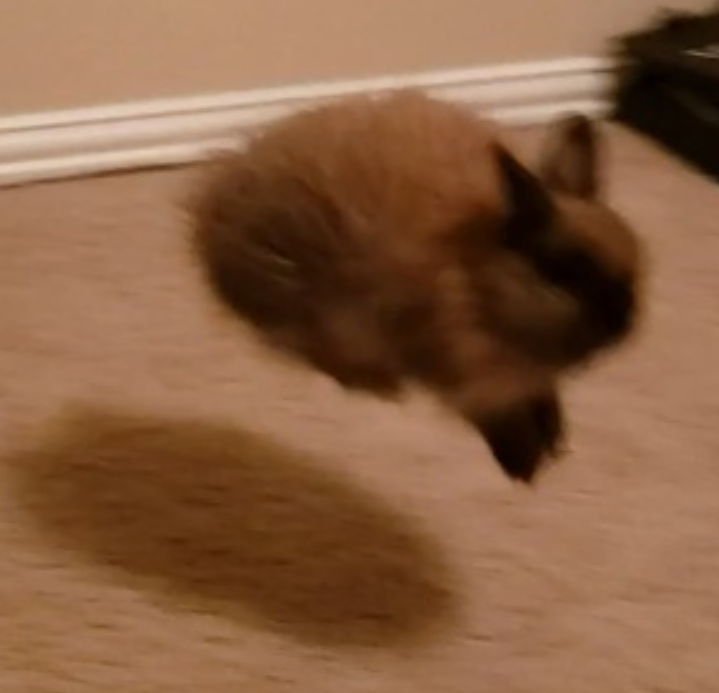

In [27]:
bun = PIL.Image.open('./images/bun.PNG')
bun

In [28]:
with torch.no_grad():
    normal_bun = prep_image(bun)
    logits = vgg(normal_bun[:3][None].cuda())
    class_probs = nn.Softmax(dim=-1)(logits).cpu().numpy()

In [29]:
sorted(class_probs[0], reverse=True)[:3]

[0.25601825, 0.11061381, 0.04269824]

In [30]:
class_probs[0].argsort()[::-1][:3]

array([284, 283, 264])

# Cloned

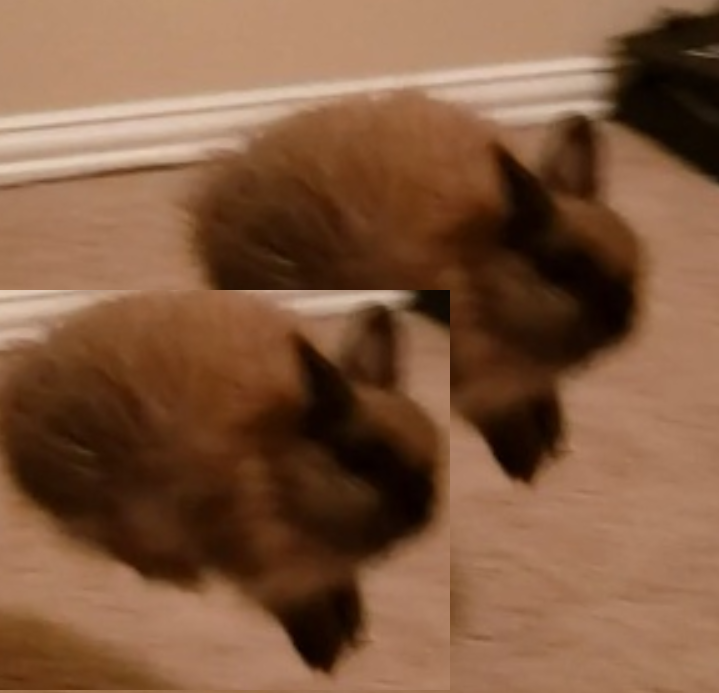

In [31]:
# Clone the rabbit
just_bun = np.array(bun)[100:500, 200:650]
bun_bun = np.array(bun).copy()
bun_bun[290:690, :450] = just_bun
bun_bun = PIL.Image.fromarray(np.uint8(bun_bun))
bun_bun

In [32]:
with torch.no_grad():
    normal_bun = prep_image(bun_bun)
    logits = vgg(normal_bun[:3][None].cuda())
    class_probs = nn.Softmax(dim=-1)(logits).cpu().numpy()

In [33]:
sorted(class_probs[0], reverse=True)[:3]

[0.6734117, 0.081192054, 0.03459925]

In [34]:
class_probs[0].argsort()[::-1][:3]

array([284, 264, 263])

# Guilty By Association

- All of these similarities become less strong as the network gets more complex

![](images/sassyjeremy.PNG)

[ImageNet labels](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) (Louise is not a Persian cat)